In [1]:
import sys
import os
import keras_rcnn
from keras_rcnn import backend, datasets, layers, models, preprocessing
import numpy
import cv2
import matplotlib
import keras
import json
import rcnn_utils
import skimage
from sklearn.model_selection import train_test_split
%matplotlib inline

/home/paperspace/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Definitions

In [2]:
train_json_file = '../input/DSB208_train.json'
# test_json_file = '/home/paperspace/bowl/DSB208_test.json'
train_path = '../input/stage1_train/'
test_path = '../input/stage1_test/'
nuclei_clust_path = '../input/nuclei_clusters.json'

target_size = (None,None)
batch_size = 1

train = True

classes = {
	"n1": 1,
	"n2": 2,
	"n3": 3
}
num_classes = len(classes) + 1

weights_path = '../models/rcnn_%sclasses.hdf5' % num_classes

build model

In [ ]:
print('building model...')
model_input = keras.layers.Input((None, None, 3))

model = keras_rcnn.models.RCNN(model_input, classes=num_classes)

model.load_weights(weights_path)

optimizer = keras.optimizers.Adam(0.0001)
# optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

model.compile(optimizer)
# model.summary(line_length=150)
# model.fit_generator(generator, epochs=10, steps_per_epoch=len(training))
# model.save_weights(weights_path)

building model...


/home/paperspace/anaconda3/lib/python3.6/site-packages/keras_rcnn/models/_rcnn.py:91: UserWarning: Output "object_detection_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "object_detection_1" during training.
  super(RCNN, self).compile(optimizer, None)


loading data...


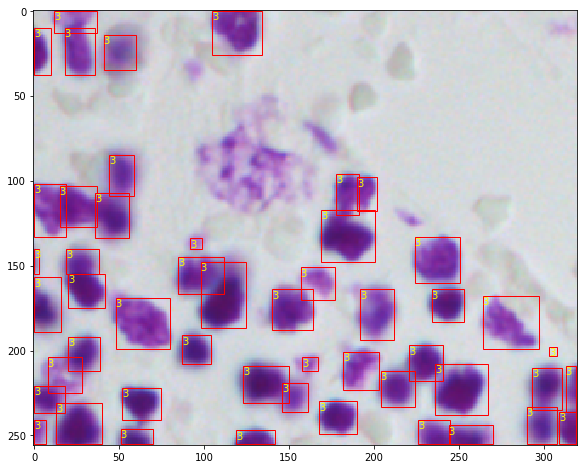

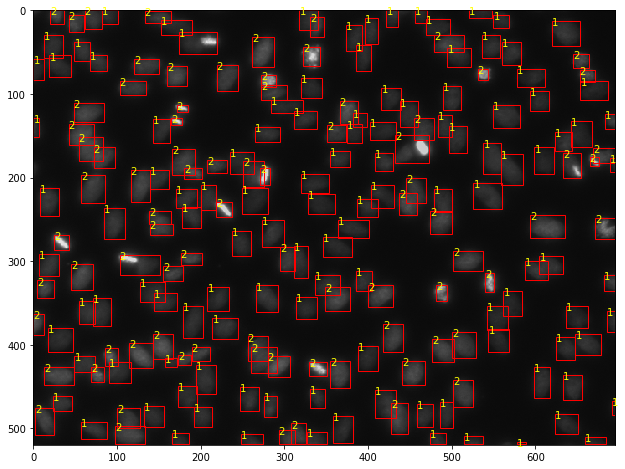

/home/paperspace/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:95: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/20
603/603 [==============================] - 515s 854ms/step - loss: 1.1694 - val_loss: 6.2304
Epoch 2/20
603/603 [==============================] - 466s 772ms/step - loss: 1.1629 - val_loss: 6.0806
Epoch 3/20
603/603 [==============================] - 508s 842ms/step - loss: 1.0908 - val_loss: 6.0548
Epoch 4/20
603/603 [==============================] - 512s 849ms/step - loss: 1.1039 - val_loss: 6.1990
Epoch 5/20
603/603 [==============================] - 488s 809ms/step - loss: 1.1671 - val_loss: 5.9344
Epoch 6/20
603/603 [==============================] - 457s 758ms/step - loss: 1.0421 - val_loss: 5.7122
Epoch 7/20
603/603 [==============================] - 458s 760ms/step - loss: 1.0289 - val_loss: 6.2806
Epoch 8/20
603/603 [==============================] - 459s 762ms/step - loss: 1.0351 - val_loss: 5.7404
Epoch 9/20
603/603 [==============================] - 455s 754ms/step - loss: 0.9327 - val_loss: 5.9258
Epoch 10/20
603/603 [==============================] - 451s 748m

In [ ]:
if train:
	with open(train_json_file, 'r') as file:
		training = json.load(file)
	with open(nuclei_clust_path, 'r') as file:
		nuclei_clusters = json.load(file)
	training, val = train_test_split(training, test_size=0.1, random_state=7)
	#with open(train_json_file, 'w') as file:
	#	json.dump(training, file)
	#sys.exit()
	#for item in training:
	#	for object_ in item['objects']:
	#		if '/DSB2018' in object_['mask']['pathname']:
	#			object_['mask']['pathname'] = '../input' + object_['mask']['pathname'][object_['mask']['pathname'].find('/DSB2018'):]
	#with open(train_json_file, 'w') as file:
	#	json.dump(training, file)
	#sys.exit()
    
	for item in training:
		#item['shape'] = (item['image']['shape']['r'], item['image']['shape']['c'], item['image']['shape']['channels'])
		#item['filename'] = item['image']['pathname']
		#item['boxes'] = []
		#for x in item['objects']:
			#item['boxes'].append({})
			#item['boxes'][-1]['class'] = x['class']
			#item['boxes'].append([x['bounding_box']['minimum']['c'], x['bounding_box']['minimum']['r'], 
			#            x['bounding_box']['maximum']['c'], x['bounding_box']['maximum']['r']])
			#item['boxes'][-1]['x1'] = x['bounding_box']['minimum']['c']
			#item['boxes'][-1]['x2'] = x['bounding_box']['maximum']['c']
			#item['boxes'][-1]['y1'] = x['bounding_box']['minimum']['r']
			#item['boxes'][-1]['y2'] = x['bounding_box']['maximum']['r']
		# item['boxes'] = []
		# for x in item['objects']:

			# item['boxes'].append([x['bounding_box']['minimum']['c'], x['bounding_box']['minimum']['r'], 
			#            x['bounding_box']['maximum']['c'], x['bounding_box']['maximum']['r']])
		item['boxes'] = numpy.array(item['boxes'])
		item['class'] = numpy.array([[0,1] for x in range(len(item['boxes']))])

	print('loading data...')
	generator = iter(rcnn_utils.train_gen(training, nuclei_clusters, num_classes, batch_size, target_size))
	val_gen = iter(rcnn_utils.train_gen(val, nuclei_clusters, num_classes, batch_size, (None, None)))
	# with open(train_json_file, 'w') as file:
	#   json.dump(training, file)
	# sys.exit()
	
	# training, validation = sklearn.model_selection.train_test_split(training)
	
	

	for _ in range(0,2):
		(target_bounding_boxes, target_image, target_scores, meta), _ = next(generator)
		target_bounding_boxes = numpy.reshape(target_bounding_boxes, (-1, 4))

		target_image = numpy.squeeze(target_image)

		target_scores = numpy.argmax(target_scores, -1)

		target_scores = numpy.reshape(target_scores, (-1))

		#print(target_bounding_boxes.shape)
		#print(target_image.shape)
		#print(target_scores.shape)

		_, axis = matplotlib.pyplot.subplots(1, figsize=(12, 8))

		axis.imshow(target_image)
		#if len(list(target_scores)) > 0:
		for target_index, target_score in enumerate(target_scores):
			if target_score > 0:
				xy = [target_bounding_boxes[target_index][0],target_bounding_boxes[target_index][1]]
				#print(xy)
				w = target_bounding_boxes[target_index][2] - target_bounding_boxes[target_index][0]
				h = target_bounding_boxes[target_index][3] - target_bounding_boxes[target_index][1]
				rectangle = matplotlib.patches.Rectangle(xy, w, h, edgecolor="r", facecolor="none")
				#print(xy, w, h)
				axis.add_patch(rectangle)
				axis.text(xy[0], xy[1]+5, target_score, color='yellow')
		matplotlib.pyplot.show()

	# sys.exit()




	# for i in range(0, 5):
	#   target_image = skimage.io.imread(training[i]['filename'])[:,:,:3]
	#   target_bounding_boxes = training[i]['boxes']
	#   target_scores = training[i]['class']
	#   #print('loading one image')
	#   #(target_bounding_boxes, target_image, target_scores, _), _ = generator.next()
	#   #print('loaded one image')
	#   #target_bounding_boxes = numpy.squeeze(target_bounding_boxes)

	#   #target_image = numpy.squeeze(target_image)

	#   # target_scores = numpy.argmax(target_scores, -1)

	#   # target_scores = numpy.squeeze(target_scores)

	#   _, axis = matplotlib.pyplot.subplots(1, figsize=(12, 8))

	#   axis.imshow(target_image)

	#   #for target_index, target_score in enumerate(target_scores):
	#   for i, box in enumerate(target_bounding_boxes):
	#       #if target_score > 0:
	#       target_score = target_scores[i]
	#       xy = [
	#           box['x1'],
	#           box['y1']
	#       ]

	#       w = box['x2'] - box['x1']
	#       h = box['y2'] - box['y1']

	#       rectangle = matplotlib.patches.Rectangle(xy, w, h, edgecolor="r", facecolor="none")

	#       axis.add_patch(rectangle)

	#   matplotlib.pyplot.show()
	checkpoint = keras.callbacks.ModelCheckpoint(weights_path, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, mode='auto', period=1)
	model.fit_generator(generator, epochs=20, steps_per_epoch=len(training)/batch_size, validation_data=val_gen, validation_steps=len(val), callbacks=[checkpoint])
	model.save_weights(weights_path)


else:
	test_generator = rcnn_utils.test_gen(test_path, num_classes)
	test_ids = next(os.walk(test_path))[1]
	# visualize prediction
	preds = []
	for i in range(0, 10):
		example = next(test_generator)
		target_bounding_boxes, target_image, target_labels, _ = example
		#target_bounding_boxes = numpy.squeeze(target_bounding_boxes)
		target_image = numpy.squeeze(target_image)
		#target_labels = numpy.argmax(target_labels, -1)
		#target_labels = numpy.squeeze(target_labels)
		# output_anchors, output_proposals, output_deltas, output_scores = model.predict(example)
		output_anchors, output_scores = model.predict(example)
		preds.append((output_anchors, output_scores))
		output_anchors = numpy.squeeze(output_anchors)
		# output_proposals = numpy.squeeze(output_proposals)
		# output_deltas = numpy.squeeze(output_deltas)
		output_scores = numpy.squeeze(output_scores)
		_, axis = matplotlib.pyplot.subplots(1)
		axis.imshow(target_image)
		axis.set_title(test_ids[i])
		#for index, label in enumerate(target_labels):
		#   if label == 1:
		#       xy = [
		#       target_bounding_boxes[index][0],
		#       target_bounding_boxes[index][1]
		#       ]
		#       w = target_bounding_boxes[index][2] - target_bounding_boxes[index][0]
		#       h = target_bounding_boxes[index][3] - target_bounding_boxes[index][1]
		#       rectangle = matplotlib.patches.Rectangle(xy, w, h, edgecolor="g", facecolor="none")
		#       axis.add_patch(rectangle)
		for index, score in enumerate(output_scores):
			#print(score)
			if max(score[1:]) > 0.4:
				xy = [
				output_anchors[index][0],
				output_anchors[index][1]
				]
				w = output_anchors[index][2] - output_anchors[index][0]
				h = output_anchors[index][3] - output_anchors[index][1]
				rectangle = matplotlib.patches.Rectangle(xy, w, h, edgecolor="r", facecolor="none")
				axis.add_patch(rectangle)